In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from tqdm import tqdm

import pandas as pd
import os

In [2]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [3]:
class food_train(Dataset):

    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[:25000]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            image = self.target_transform(label)
        
        return image, label

In [4]:
class food_val(Dataset):

    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[25000:]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            image = self.target_transform(label)
        
        return image, label

In [5]:
class food_test(Dataset):

    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = read_image(img_path)
       
        if self.transform:
            image = self.transform(image)
        
        return file_name, image

In [14]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

transform = transforms.Compose(
                    [transforms.Resize((256,256)),
                     transforms.ConvertImageDtype(torch.float),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])])

train_set = food_train(labels, img_dir, transform = transform)
trainloader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)

val_set = food_val(labels, img_dir, transform = transform)
valloader = DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0)


len(train_set), len(val_set)

(25000, 5611)

In [7]:
test_set = food_test("../data/test_set/test_set", transform = transform)
testloader = DataLoader(test_set, batch_size = 32, shuffle=True, num_workers=0)

len(test_set)

7653

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


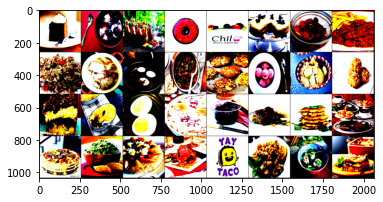

tensor(56) tensor(9) tensor(38) tensor(43) tensor(41) tensor(61) tensor(12) tensor(34)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

batch_size = 8

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

In [9]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080'

In [10]:
resnet = models.resnet18(pretrained=True)

resnet.classifier = nn.Linear(512, 81)

resnet.to(device);

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [15]:
def train_loop(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    
    model.train()
    for epoch in range(5):
        for batch, (image, label) in enumerate(dataloader):
            # Compute prediction and loss
            image, label = image.to(device), label.to(device)
            pred = model(image)
            loss = criterion(pred, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 200 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch}")
                
        print(f"Epoch: {epoch}")
        test_loop(valloader, resnet, criterion)


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
train_loop(trainloader, resnet, criterion, optimizer)

loss: 2.162131  [    0/25000] epoch: 0
loss: 2.136808  [ 3200/25000] epoch: 0
loss: 1.750791  [ 6400/25000] epoch: 0
loss: 1.731623  [ 9600/25000] epoch: 0
loss: 1.833570  [12800/25000] epoch: 0
loss: 2.120660  [16000/25000] epoch: 0
loss: 1.288514  [19200/25000] epoch: 0
loss: 2.684976  [22400/25000] epoch: 0
Epoch: 0
Test Error: 
 Accuracy: 49.8%, Avg loss: 1.994933 

loss: 1.779442  [    0/25000] epoch: 1
loss: 1.924853  [ 3200/25000] epoch: 1
loss: 1.677375  [ 6400/25000] epoch: 1
loss: 1.984255  [ 9600/25000] epoch: 1
loss: 1.779712  [12800/25000] epoch: 1
loss: 1.079678  [16000/25000] epoch: 1
loss: 1.052743  [19200/25000] epoch: 1
loss: 1.360638  [22400/25000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 51.6%, Avg loss: 1.933023 

loss: 0.296024  [    0/25000] epoch: 2
loss: 0.701001  [ 3200/25000] epoch: 2
loss: 0.791915  [ 6400/25000] epoch: 2
loss: 0.910121  [ 9600/25000] epoch: 2
loss: 1.344705  [12800/25000] epoch: 2
loss: 1.433419  [16000/25000] epoch: 2
loss: 1.789770  [192

In [17]:
# PATH = '../../models/normalized_transfered_resnet.pth'
# torch.save(resnet.state_dict(), PATH)

In [24]:
resnet2 = models.resnet18()
resnet2.load_state_dict(torch.load("../../transfered_resnet.pth"))
resnet2.to(device);

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = resnet2(X).argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

100%|████████████████████████████████████████| 240/240 [02:49<00:00,  1.42it/s]


In [26]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_6060.jpg,21
1,test_3540.jpg,6
2,test_4430.jpg,72
3,test_695.jpg,10
4,test_4999.jpg,37


In [27]:
test_df.to_csv("submission.csv", index=False)